In [4]:
%load_ext autoreload
%load_ext line_profiler
%load_ext snakeviz

%autoreload 2

In [5]:
import numpy as np
import os
import cProfile, pstats
from flatland.core.grid.grid4_astar import a_star

from flatland.core.grid.grid4_astar import set_priority

# In Flatland you can use custom observation builders and predicitors
# Observation builders generate the observation needed by the controller
# Preditctors can be used to do short time prediction which can help in avoiding conflicts in the network
from flatland.envs.malfunction_generators import malfunction_from_params, MalfunctionParameters, ParamMalfunctionGen

from flatland.envs.observations import GlobalObsForRailEnv
# First of all we import the Flatland rail environment
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_env import RailEnvActions
from flatland.envs.rail_generators import sparse_rail_generator
#from flatland.envs.sparse_rail_gen import SparseRailGen
from flatland.envs.line_generators import sparse_line_generator
# We also include a renderer because we want to visualize what is going on in the environment
from flatland.utils.rendertools import RenderTool, AgentRenderVariant

import matplotlib.pyplot as plt

In [6]:
width = 100 # With of map
height = 100  # Height of map
nr_trains = 2  # Number of trains that have an assigned task in the env
cities_in_map = 20# Number of cities where agents can start or end
seed = 100  # Random seed
grid_distribution_of_cities = False  # Type of city distribution, if False cities are randomly placed
max_rails_between_cities = 25  # Max number of tracks allowed between cities. This is number of entry point to a city
max_rail_in_cities = 25 # Max number of parallel tracks within a city, representing a realistic trainstation

In [7]:
rail_generator = sparse_rail_generator(max_num_cities=cities_in_map,
                                       seed=seed,
                                       grid_mode=grid_distribution_of_cities,
                                       max_rails_between_cities=max_rails_between_cities,
                                       max_rail_pairs_in_city=max_rail_in_cities//2,
                                       )

In [8]:
speed_ration_map = {1.: 0.25,  # Fast passenger train
                    1. / 2.: 0.25,  # Fast freight train
                    1. / 3.: 0.25,  # Slow commuter train
                    1. / 4.: 0.25}  # Slow freight train

In [9]:
line_generator = sparse_line_generator(speed_ration_map)

stochastic_data = MalfunctionParameters(malfunction_rate=1/10000,  # Rate of malfunction occurence
                                        min_duration=15,  # Minimal duration of malfunction
                                        max_duration=50  # Max duration of malfunction
                                        )

observation_builder = GlobalObsForRailEnv()

from flatland.envs.malfunction_generators import Malfunction

class NoMalfunctionGenerator:
    def generate(self, np_random):
        return Malfunction(0)

class AlwaysThreeStepMalfunction:
    def generate(self, np_random):
        return Malfunction(3)

def test_waiting_no_transition():
    env = get_small_two_agent_env()
    env.malfunction_generator = NoMalfunctionGenerator()


In [10]:
env = RailEnv(width=width,
              height=height,
              rail_generator=rail_generator,
              line_generator=line_generator,
              number_of_agents=nr_trains,
              obs_builder_object=observation_builder,
              #malfunction_generator_and_process_data=malfunction_from_params(stochastic_data),
              malfunction_generator=ParamMalfunctionGen(stochastic_data),
              remove_agents_at_target=True,
              random_seed=seed)
env.reset(random_seed= seed);

C:\Users\robin\Documents\EPFL\BA6\Bachelor_project\flatland-rl\flatland\envs\rail_generators.py:303: UserWarning: Could not set all required cities! Created 4/9
  warnings.warn(city_warning)


In [11]:
set_priority(False)
profiler = cProfile.Profile()
profiler.enable() 
env.reset(random_seed= seed);
profiler.disable()
stats = pstats.Stats(profiler)
%snakeviz env.reset(random_seed=seed)

 
*** Profile stats marshalled to file 'C:\\Users\\robin\\AppData\\Local\\Temp\\tmp__3nextm'.
Embedding SnakeViz in this document...
<function display at 0x00000177B2A25510>


In [12]:

set_priority(True)

profiler = cProfile.Profile()
profiler.enable() 
env.reset(random_seed= seed);
profiler.disable()
stats = pstats.Stats(profiler)
%snakeviz env.reset(random_seed=seed)

 
*** Profile stats marshalled to file 'C:\\Users\\robin\\AppData\\Local\\Temp\\tmplg6wssdi'.
Embedding SnakeViz in this document...
<function display at 0x00000177B2A25510>


In [52]:
set_priority(True)
%lprun -f a_star env.reset(random_seed=seed)

Timer unit: 1e-07 s

Total time: 18.9325 s
File: C:\Users\robin\Documents\EPFL\BA6\Bachelor_project\flatland-rl\flatland\core\grid\grid4_astar.py
Function: a_star at line 46

Line #      Hits         Time  Per Hit   % Time  Line Contents
    46                                           def a_star(grid_map: GridTransitionMap, start: IntVector2D, end: IntVector2D,
    47                                                      a_star_distance_function: IntVector2DDistance = Vec2d.get_manhattan_distance, avoid_rails=False,
    48                                                      respect_transition_validity=True, forbidden_cells: IntVector2DArray = None) -> IntVector2DArray:
    49                                               """
    50                                           
    51                                               :param avoid_rails:
    52                                               :param grid_map: Grid Map where the path is found in
    53                             

In [13]:
def create_env(height, width, nr_cities, max_rail_in_cities, max_rail_btw_cities, 
               seed, grid_mode = False):
    nr_agent = 2
    stochastic_data = MalfunctionParameters(malfunction_rate=1/10000,  # Rate of malfunction occurence
                                        min_duration=15,  # Minimal duration of malfunction
                                        max_duration=50  # Max duration of malfunction
                                        )
    speed_ration_map = {1.: 0.25,  # Fast passenger train
                    1. / 2.: 0.25,  # Fast freight train
                    1. / 3.: 0.25,  # Slow commuter train
                    1. / 4.: 0.25}  # Slow freight train
    line_generator = sparse_line_generator(speed_ration_map)
    
    observation_builder = GlobalObsForRailEnv()
    
    rail_generator = sparse_rail_generator(max_num_cities=nr_cities,
                                       seed=seed,
                                       grid_mode=grid_distribution_of_cities,
                                       max_rails_between_cities=max_rail_btw_cities,
                                       max_rail_pairs_in_city=max_rail_in_cities//2)
    env = RailEnv(width=width,
                  height=height,
                  rail_generator=rail_generator,
                  line_generator=line_generator,
                  number_of_agents=nr_agent,
                  obs_builder_object=observation_builder,
                  malfunction_generator=ParamMalfunctionGen(stochastic_data),
                  remove_agents_at_target=True,
                  random_seed=seed)
    return env

In [25]:
import time


print("BENCHMARK: A*\n")
print("|  Parameters   |     height     |      width     |  nr_cities    |max_rail_in_cities|max_rail_btw_cities|  Execution time  ")
print("-------------------------------------------------------------------------------------------------------------------------------------------")
for size in range(50, 200, 50):
    height = size
    width = size
    for nr_cities in range(2, 20, 2):
        for max_rail_in_cities in range(2,10, 2):
            for max_rail_btw_cities in range(2,10, 2):

                env = create_env(height, width, nr_cities, max_rail_in_cities, max_rail_btw_cities, 
                seed)
                time1= time.time()
                env.reset()
                time2 = time.time()
                delta = time2-time1
                print(f"|  Parameters   |        {height}      |        {width}      |       {nr_cities}       |        {max_rail_in_cities}         |         {max_rail_btw_cities}        |        {delta}            ")


                
                
        

BENCHMARK: A*

|  Parameters   |     height     |      width     |  nr_cities    |max_rail_in_cities|max_rail_btw_cities|  Execution time  
-------------------------------------------------------------------------------------------------------------------------------------------
|  Parameters   |        50      |        50      |       2       |        2         |         2        |        0.11939215660095215            
|  Parameters   |        50      |        50      |       2       |        2         |         4        |        0.06924605369567871            
|  Parameters   |        50      |        50      |       2       |        2         |         6        |        0.08017754554748535            
|  Parameters   |        50      |        50      |       2       |        2         |         8        |        0.05981922149658203            
|  Parameters   |        50      |        50      |       2       |        4         |         2        |        0.0977783203125            

C:\Users\robin\Documents\EPFL\BA6\Bachelor_project\flatland-rl\flatland\envs\rail_generators.py:303: UserWarning: Could not set all required cities! Created 6/8
  warnings.warn(city_warning)


|  Parameters   |        50      |        50      |       8       |        8         |         2        |        0.4232649803161621            
|  Parameters   |        50      |        50      |       8       |        8         |         4        |        0.4595530033111572            
|  Parameters   |        50      |        50      |       8       |        8         |         6        |        0.47788548469543457            
|  Parameters   |        50      |        50      |       8       |        8         |         8        |        0.46206068992614746            
|  Parameters   |        50      |        50      |       10       |        2         |         2        |        0.24933242797851562            
|  Parameters   |        50      |        50      |       10       |        2         |         4        |        0.2573416233062744            
|  Parameters   |        50      |        50      |       10       |        2         |         6        |        0.365701675415039

C:\Users\robin\Documents\EPFL\BA6\Bachelor_project\flatland-rl\flatland\envs\rail_generators.py:303: UserWarning: Could not set all required cities! Created 8/10
  warnings.warn(city_warning)


|  Parameters   |        50      |        50      |       10       |        6         |         2        |        0.3620293140411377            
|  Parameters   |        50      |        50      |       10       |        6         |         4        |        0.5562436580657959            
|  Parameters   |        50      |        50      |       10       |        6         |         6        |        0.38843822479248047            
|  Parameters   |        50      |        50      |       10       |        6         |         8        |        0.3631439208984375            


C:\Users\robin\Documents\EPFL\BA6\Bachelor_project\flatland-rl\flatland\envs\rail_generators.py:303: UserWarning: Could not set all required cities! Created 6/9
  warnings.warn(city_warning)


|  Parameters   |        50      |        50      |       10       |        8         |         2        |        0.47961950302124023            
|  Parameters   |        50      |        50      |       10       |        8         |         4        |        0.4505746364593506            
|  Parameters   |        50      |        50      |       10       |        8         |         6        |        0.43120598793029785            
|  Parameters   |        50      |        50      |       10       |        8         |         8        |        0.46654534339904785            
|  Parameters   |        50      |        50      |       12       |        2         |         2        |        0.3271462917327881            
|  Parameters   |        50      |        50      |       12       |        2         |         4        |        0.34707212448120117            
|  Parameters   |        50      |        50      |       12       |        2         |         6        |        0.2400722503

C:\Users\robin\Documents\EPFL\BA6\Bachelor_project\flatland-rl\flatland\envs\rail_generators.py:303: UserWarning: Could not set all required cities! Created 10/12
  warnings.warn(city_warning)


|  Parameters   |        50      |        50      |       12       |        4         |         2        |        0.4099290370941162            
|  Parameters   |        50      |        50      |       12       |        4         |         4        |        0.3315892219543457            
|  Parameters   |        50      |        50      |       12       |        4         |         6        |        0.3725430965423584            
|  Parameters   |        50      |        50      |       12       |        4         |         8        |        0.42456674575805664            


C:\Users\robin\Documents\EPFL\BA6\Bachelor_project\flatland-rl\flatland\envs\rail_generators.py:303: UserWarning: Could not set all required cities! Created 8/12
  warnings.warn(city_warning)


|  Parameters   |        50      |        50      |       12       |        6         |         2        |        0.38416314125061035            
|  Parameters   |        50      |        50      |       12       |        6         |         4        |        0.45217061042785645            
|  Parameters   |        50      |        50      |       12       |        6         |         6        |        0.5378570556640625            
|  Parameters   |        50      |        50      |       12       |        6         |         8        |        0.42566585540771484            
|  Parameters   |        50      |        50      |       12       |        8         |         2        |        0.37057924270629883            
|  Parameters   |        50      |        50      |       12       |        8         |         4        |        0.516366720199585            
|  Parameters   |        50      |        50      |       12       |        8         |         6        |        0.41429066658

C:\Users\robin\Documents\EPFL\BA6\Bachelor_project\flatland-rl\flatland\envs\rail_generators.py:303: UserWarning: Could not set all required cities! Created 10/14
  warnings.warn(city_warning)


|  Parameters   |        50      |        50      |       14       |        4         |         2        |        0.44782590866088867            
|  Parameters   |        50      |        50      |       14       |        4         |         4        |        0.4533970355987549            
|  Parameters   |        50      |        50      |       14       |        4         |         6        |        0.3608887195587158            
|  Parameters   |        50      |        50      |       14       |        4         |         8        |        0.41249799728393555            


C:\Users\robin\Documents\EPFL\BA6\Bachelor_project\flatland-rl\flatland\envs\rail_generators.py:303: UserWarning: Could not set all required cities! Created 8/14
  warnings.warn(city_warning)


|  Parameters   |        50      |        50      |       14       |        6         |         2        |        0.40432024002075195            
|  Parameters   |        50      |        50      |       14       |        6         |         4        |        0.3679969310760498            
|  Parameters   |        50      |        50      |       14       |        6         |         6        |        0.5485506057739258            
|  Parameters   |        50      |        50      |       14       |        6         |         8        |        0.36502861976623535            
|  Parameters   |        50      |        50      |       14       |        8         |         2        |        0.41667604446411133            
|  Parameters   |        50      |        50      |       14       |        8         |         4        |        0.5288712978363037            
|  Parameters   |        50      |        50      |       14       |        8         |         6        |        0.48350453376

C:\Users\robin\Documents\EPFL\BA6\Bachelor_project\flatland-rl\flatland\envs\rail_generators.py:303: UserWarning: Could not set all required cities! Created 10/16
  warnings.warn(city_warning)


|  Parameters   |        50      |        50      |       16       |        4         |         2        |        0.5027594566345215            
|  Parameters   |        50      |        50      |       16       |        4         |         4        |        0.3783574104309082            
|  Parameters   |        50      |        50      |       16       |        4         |         6        |        0.3508894443511963            
|  Parameters   |        50      |        50      |       16       |        4         |         8        |        0.3470280170440674            


C:\Users\robin\Documents\EPFL\BA6\Bachelor_project\flatland-rl\flatland\envs\rail_generators.py:303: UserWarning: Could not set all required cities! Created 8/16
  warnings.warn(city_warning)


|  Parameters   |        50      |        50      |       16       |        6         |         2        |        0.503532886505127            
|  Parameters   |        50      |        50      |       16       |        6         |         4        |        0.40795063972473145            
|  Parameters   |        50      |        50      |       16       |        6         |         6        |        0.444568395614624            
|  Parameters   |        50      |        50      |       16       |        6         |         8        |        0.4395744800567627            
|  Parameters   |        50      |        50      |       16       |        8         |         2        |        0.459672212600708            
|  Parameters   |        50      |        50      |       16       |        8         |         4        |        0.6315765380859375            
|  Parameters   |        50      |        50      |       16       |        8         |         6        |        0.5645730495452881

C:\Users\robin\Documents\EPFL\BA6\Bachelor_project\flatland-rl\flatland\envs\rail_generators.py:303: UserWarning: Could not set all required cities! Created 17/18
  warnings.warn(city_warning)


|  Parameters   |        50      |        50      |       18       |        2         |         2        |        0.4855804443359375            
|  Parameters   |        50      |        50      |       18       |        2         |         4        |        0.4798400402069092            
|  Parameters   |        50      |        50      |       18       |        2         |         6        |        0.39470958709716797            
|  Parameters   |        50      |        50      |       18       |        2         |         8        |        0.43793392181396484            
|  Parameters   |        50      |        50      |       18       |        4         |         2        |        0.3939402103424072            
|  Parameters   |        50      |        50      |       18       |        4         |         4        |        0.44615650177001953            
|  Parameters   |        50      |        50      |       18       |        4         |         6        |        0.48728084564

In [23]:
env_renderer = RenderTool(env,
                          agent_render_variant=AgentRenderVariant.ONE_STEP_BEHIND,
                          show_debug=False,
                          screen_height=1020,  # Adjust these parameters to fit your resolution
                          screen_width=1800)

env.malfunction_generator = NoMalfunctionGenerator()

In [24]:
def show_env(env_renderer):
    env_renderer.render_env(show=False,  # whether to call matplotlib show() or equivalent after completion
                                show_agents=True,  # whether to include agents
                                show_inactive_agents=False,  # whether to show agents before they start
                                show_observations=True,  # whether to include observations
                                show_predictions=True,  # whether to include predictions
                                show_rowcols=True,  # label the rows and columns
                                frames=True,  # frame counter to show (intended since invocation)
                                episode=None,  # int episode number to show
                                step=None,  # int step number to show in image
                                selected_agent=None)  # indicate which agent is "selected" in the editor):
    plt.imshow(env_renderer.get_image())

In [54]:
from flatland.core.grid.grid_utils import IntVector2D
from flatland.core.grid.rail_env_grid import RailEnvTransitions
from flatland.core.transition_map import GridTransitionMap
import time
import random as rd

rail_trans = RailEnvTransitions()
grid_map = GridTransitionMap(width=width, height=height, transitions=rail_trans)
time1 = time.time()
for i in range(25):
    start = tuple((np.random.randint(low=0,high=width-1), np.random.randint(low=0, high=height-1)))
    end = tuple((np.random.randint(low=0, high=width-1), np.random.randint(low=0,high=height-1)))     
    a_star(grid_map=grid_map,start = start, end = end)
time2 = time.time()
print(time2-time1)

6.101663589477539


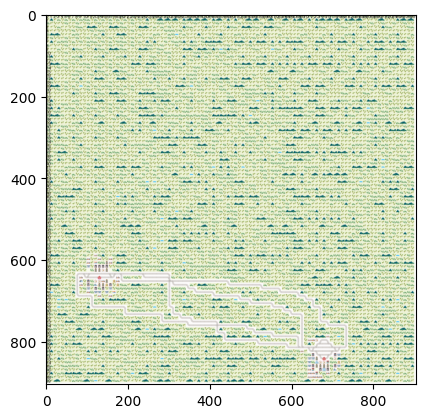

In [25]:
show_env(env_renderer)

In [20]:
print("Initial positions",  [a.initial_position for a in env.agents])
print("Initial directions", [a.initial_direction for a in env.agents])
print("Earliest Departures", [a.earliest_departure for a in env.agents])
print("Targets", [a.target for a in env.agents])
print("Speed Counter values", [a.speed_counter.max_count for a in env.agents])

Initial positions [(14, 20), (24, 6)]
Initial directions [1, 1]
Earliest Departures [15, 122]
Targets [(25, 6), (17, 20)]
Speed Counter values [2, 1]


In [21]:
def show_agents(env):
    for agent in env.agents:
        print(agent.handle, "Position", agent.position, "State", agent.state, end='\t')
    print()

In [22]:
for _ in range(max(a.earliest_departure for a in env.agents)+ 1):
    env.step({0: RailEnvActions.DO_NOTHING, 1: RailEnvActions.DO_NOTHING})
show_agents(env)

0 Position None State TrainState.READY_TO_DEPART	1 Position None State TrainState.READY_TO_DEPART	


0 Position (14, 20) State TrainState.MOVING	1 Position (24, 6) State TrainState.MOVING	
0 Position (14, 20) State TrainState.MOVING	1 Position (24, 6) State TrainState.MOVING	
0 Position (14, 20) State TrainState.MOVING	1 Position (24, 7) State TrainState.MOVING	
0 Position (14, 21) State TrainState.MOVING	1 Position (24, 7) State TrainState.MOVING	
0 Position (14, 21) State TrainState.MOVING	1 Position (24, 8) State TrainState.MOVING	
0 Position (14, 21) State TrainState.MOVING	1 Position (24, 8) State TrainState.MOVING	
0 Position (14, 22) State TrainState.MOVING	1 Position (23, 8) State TrainState.MOVING	
0 Position (14, 22) State TrainState.MOVING	1 Position (23, 8) State TrainState.MOVING	
0 Position (14, 22) State TrainState.MOVING	1 Position (23, 9) State TrainState.MOVING	


C:\Users\robin\Documents\EPFL\BA6\Bachelor_project\flatland-rl\flatland\utils\rendertools.py:397: UserWarning: Predictor did not provide any predicted cells to render.                 Observation builder needs to populate: env.dev_obs_dict
  warnings.warn(
C:\Users\robin\Documents\EPFL\BA6\Bachelor_project\flatland-rl\flatland\utils\rendertools.py:418: UserWarning: Predictor did not provide any predicted cells to render.                 Predictors builder needs to populate: env.dev_pred_dict
  warnings.warn(


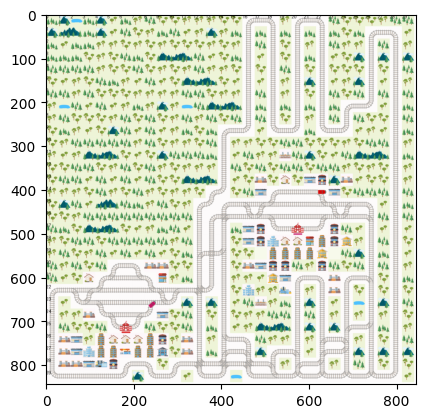

In [23]:
for _ in range(9):
    action_dict = {}
    action_dict[0] = RailEnvActions.MOVE_FORWARD
    action_dict[1] = RailEnvActions.MOVE_FORWARD
    env.step(action_dict);
    show_agents(env)
show_env(env_renderer)

In [ ]:
env.agents[1].malfunction_handler._set_malfunction_down_counter(100)
show_agents(env)
show_env(env_renderer)

In [ ]:
for _ in range(2):
    action_dict = {}
    action_dict[0] = RailEnvActions.MOVE_FORWARD
    action_dict[1] = RailEnvActions.STOP_MOVING
    env.step(action_dict);
    show_agents(env)
show_env(env_renderer)

In [ ]:
show_agents(env)

In [ ]:
action_dict = {}
action_dict[0] = RailEnvActions.MOVE_FORWARD
action_dict[1] = RailEnvActions.STOP_MOVING
env.step(action_dict);
show_agents(env)
show_env(env_renderer)

In [ ]:
import numpy as np
import os

from flatland.envs.malfunction_generators import malfunction_from_params, MalfunctionParameters, ParamMalfunctionGen

from flatland.envs.observations import GlobalObsForRailEnv
# First of all we import the Flatland rail environment
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_env import RailEnvActions
from flatland.envs.rail_generators import sparse_rail_generator
#from flatland.envs.sparse_rail_gen import SparseRailGen
from flatland.envs.schedule_generators import sparse_schedule_generator


def get_small_two_agent_env():
    """Generates a simple 2 city 2 train env returns it after reset"""
    width = 30  # With of map
    height = 15  # Height of map
    nr_trains = 2  # Number of trains that have an assigned task in the env
    cities_in_map = 2 # Number of cities where agents can start or end
    seed = 42  # Random seed
    grid_distribution_of_cities = False  # Type of city distribution, if False cities are randomly placed
    max_rails_between_cities = 2  # Max number of tracks allowed between cities. This is number of entry point to a city
    max_rail_in_cities = 6  # Max number of parallel tracks within a city, representing a realistic trainstation

    rail_generator = sparse_rail_generator(max_num_cities=cities_in_map,
                                        seed=seed,
                                        grid_mode=grid_distribution_of_cities,
                                        max_rails_between_cities=max_rails_between_cities,
                                        max_rail_pairs_in_city=max_rail_in_cities//2,
                                        )
    speed_ration_map = {1.: 0.25,  # Fast passenger train
                    1. / 2.: 0.25,  # Fast freight train
                    1. / 3.: 0.25,  # Slow commuter train
                    1. / 4.: 0.25}  # Slow freight train

    schedule_generator = sparse_schedule_generator(speed_ration_map)


    stochastic_data = MalfunctionParameters(malfunction_rate=1/10000,  # Rate of malfunction occurence
                                        min_duration=15,  # Minimal duration of malfunction
                                        max_duration=50  # Max duration of malfunction
                                        )

    observation_builder = GlobalObsForRailEnv()

    env = RailEnv(width=width,
                height=height,
                rail_generator=rail_generator,
                schedule_generator=schedule_generator,
                number_of_agents=nr_trains,
                obs_builder_object=observation_builder,
                #malfunction_generator_and_process_data=malfunction_from_params(stochastic_data),
                malfunction_generator=ParamMalfunctionGen(stochastic_data),
                remove_agents_at_target=True,
                random_seed=seed)

    env.reset()

    return env

In [ ]:
env = get_small_two_agent_env()

env_renderer = RenderTool(env,
                          agent_render_variant=AgentRenderVariant.ONE_STEP_BEHIND,
                          show_debug=False,
                          screen_height=600,  # Adjust these parameters to fit your resolution
                          screen_width=800)

i_agent = 1
ed = env.agents[i_agent].earliest_departure
for _ in range(ed):
    env.step({i_agent: RailEnvActions.DO_NOTHING})

show_agents(env)
show_env(env_renderer)

In [ ]:
for _ in range(50):
    env.step({i_agent: RailEnvActions.MOVE_FORWARD})

show_agents(env)
show_env(env_renderer)

In [ ]:
show_agents(env)
show_env(env_renderer)
